In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm # 指数分布の機能を提供するオブジェクト

In [2]:
class Robot(IdealRobot):
    # noise_per_meter:1mあたりの小石の数 noise_std:小石を踏んだときにロボットの向きに発生する雑音の標準偏差
    def __init__(self, pose, agent = None, sensor = None , color = "black",
               noise_per_meter = 5, noise_std = math.pi/60):
        
        super().__init__(pose,agent,sensor,color) # super() IdealRobotのinitを呼び出す
        
        self.noise_pdf = expon(scale = 1.0 / (1e-100 + noise_per_meter)) # scale = 1/(λ + 10^-100)
        #print(self.noise_pdf)
        self.distance_until_noise = self.noise_pdf.rvs()
        #print(self.distance_until_noise)
        self.theta_noise = norm(scale = noise_std) # 小石踏んだときの誤差する角度
        #print(self.theta_noise)
        
    def noise(self,pose,nu,omega,time_interval):
        # 直進と回転で進む床面の距離
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0: # distance_until_noiseが0かどうか判定
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu,omega,time_interval,self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)


<IPython.core.display.Javascript object>


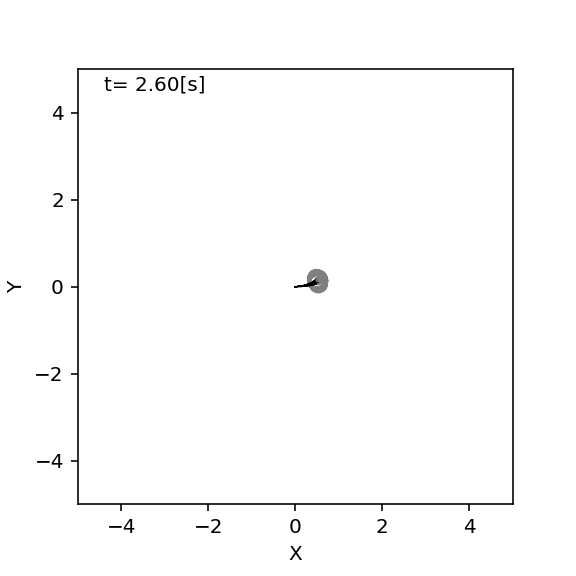

In [3]:
world = World(30,0.1)

for i in range(100):# 100台のrobot
    circling = Agent(0.2,10.0 / 180 * math.pi)
    r = Robot(np.array([0,0,0]).T,sensor = None,agent = circling,color = "gray") # robotの用意
    world.append(r) # 用意したrobotをworld座標系に入れる
world.draw()